## Homework 10 Assignment 2

In [1]:
# discussed the beginning with Sam Burns (shb395), 
# utilized the conversation the class had on slack for assistance 
# see readme for more details

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
import pylab as pl
import pandas as pd
import os
import urllib
import geopandas as gpd
import seaborn as sns
import matplotlib as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)



## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

In [3]:
#read in the energy and water csv

In [4]:
nrg = pd.read_csv('https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD')

In [5]:
nrg.head()

,Record Number,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
0,12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
4,15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#read in the manhattan pluto csv

In [7]:
#environmental variable
#create the env variable since previous doesn't work
os.environ["PUIDATA"] = "%s/PUI2018/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/sjf374/PUI2018/PUIdata


In [8]:
url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'
filename = 'pluto.gz'
dest = 'plutofile'

In [9]:
boroughs = ['BK', 'BX', 'MN', 'QN', 'SI']

In [10]:
def zips(url, filename, destination):
    print ("Downloading")
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        print ("no zip in puidata")
        if not os.path.isfile(filename):
            print ("no zip in current folder")
            os.system("curl " + url + " > " + filename)          

    os.system("mv " + filename + " " + os.getenv("PUIDATA"))
    print ("moving zipped file")
    
    ### unzip the csv 
    os.system("unzip " + os.getenv("PUIDATA") + "/" + filename + " -d " + os.getenv("PUIDATA") + "/" + destination)
    print ("unzipped file")

    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        print ("WARNING!!! something is wrong: the %s file is not there!" % (x))

    else:
        print ("file in place, you can continue")

In [11]:
zips(url, filename, dest)

Downloading
moving zipped file
unzipped file
file in place, you can continue


In [12]:
#load in the geodataframe
bsize = gpd.read_file(os.getenv("PUIDATA") + '/' + dest + '/MNMapPLUTO.shp')

In [13]:
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_area,SHAPE_len,geometry
0,MN,1545,52,108,138,4000,02,5,10028,E022,...,0.000000e+00,None,1,None,None,18V1,0,2867.154705,260.428942,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,MN,723,7501,104,93,6000,02,3,10001,E003,...,1.007230e+09,11/30/2006,1,None,None,18V1,7,10907.639931,417.764545,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,MN,1680,48,111,170,5000,04,8,10029,E091,...,0.000000e+00,None,1,1,1,18V1,0,2665.033424,256.893308,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,MN,1385,32,108,130,2003,02,4,10021,E039,...,0.000000e+00,None,1,None,None,18V1,0,15302.920914,505.033271,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,MN,1197,27,107,169,5000,03,6,10024,E074,...,0.000000e+00,None,1,None,None,18V1,0,4374.612456,295.652483,"POLYGON ((992273.6849975586 224863.4904174805,..."


In [14]:
type(bsize)

geopandas.geodataframe.GeoDataFrame

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

Text(0.5,1,'Energy Consumption scatter matrix')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


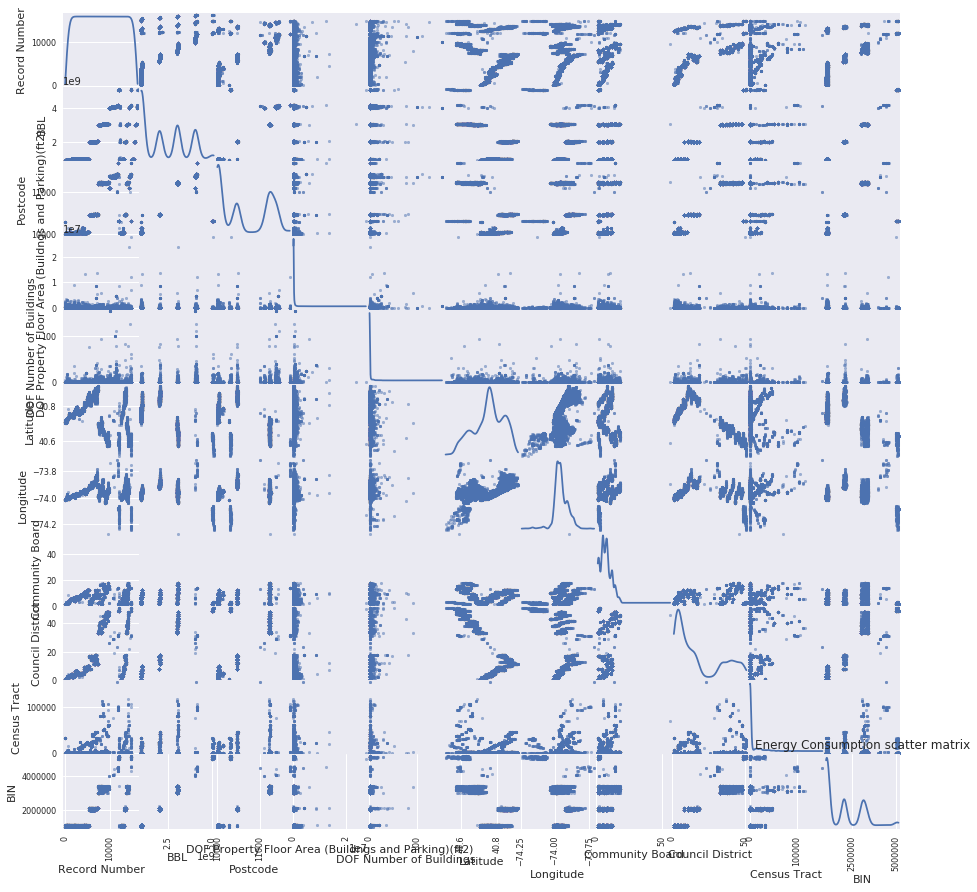

In [15]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(15, 15), diagonal='kde')
pl.title('Energy Consumption scatter matrix')

Figure 1:This graph has many scatter plots. Each field in the dataframe is graphed against each other field in the data frame. We more easily seem which fields are categorical like BLL and BIN. The few that have a very strong visual correlation like latitude and council district don't seem to be of high importance

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'Heatmap of correlations for Energy Consumption')

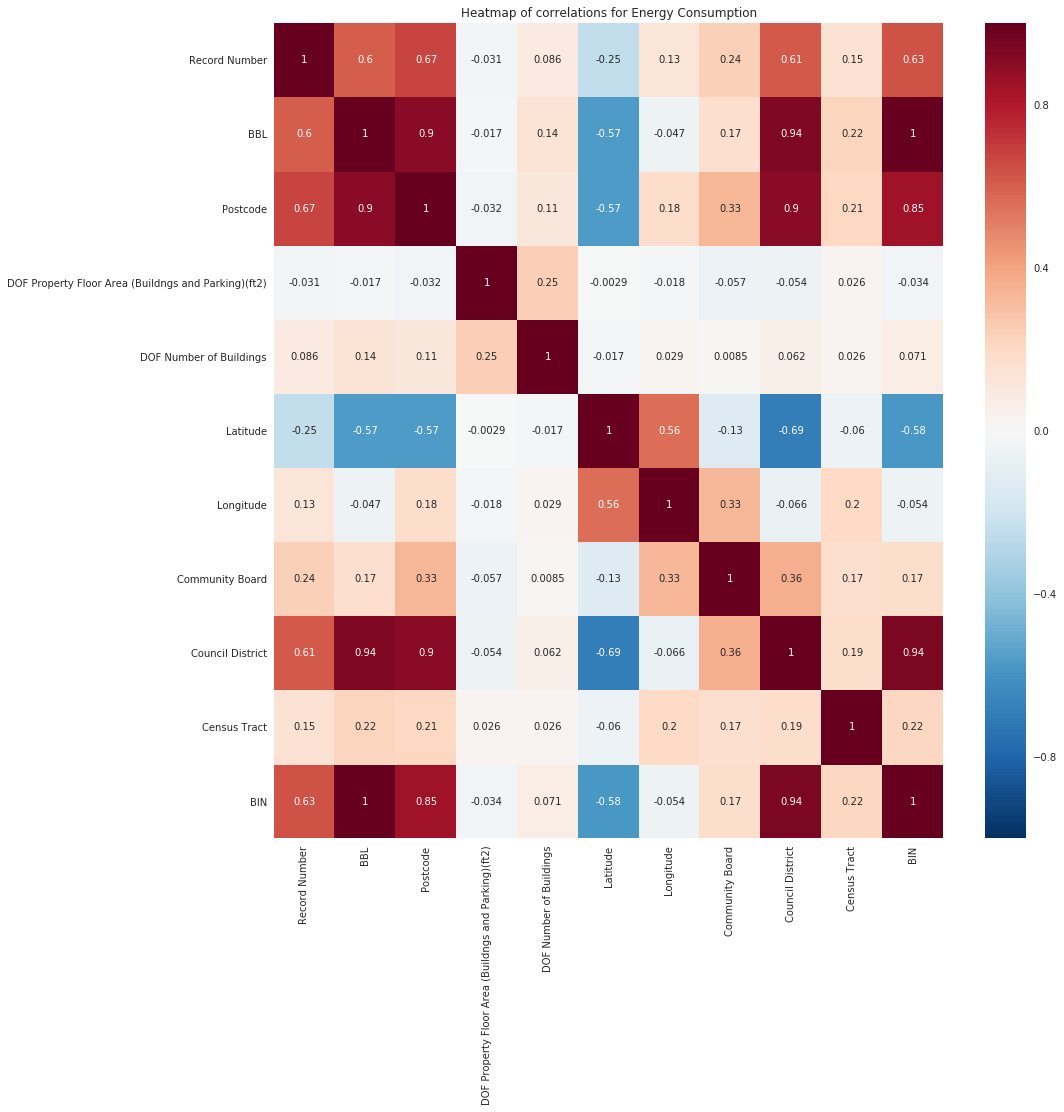

In [16]:
pl.figure(figsize = (15,15))
sns.heatmap(nrg.corr(), annot=True)
pl.title('Heatmap of correlations for Energy Consumption')

Figure 2: Though not a scatter plot, this graph shows which fields are correlated in a numerical sense. We see low correlations for most fields with one of the continuous varibles (property floor area), but some very slight positive correlations with number of buildings. 

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [17]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [18]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [19]:
#remove unnecassary columns

nrg = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [20]:
#remove unnecassary columns
bsize = bsize[['UnitsRes', 'UnitsTotal', 'YearBuilt', 'BBL', 'geometry']]
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


Text(0.5,1,'PLUTO scatter matrix')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


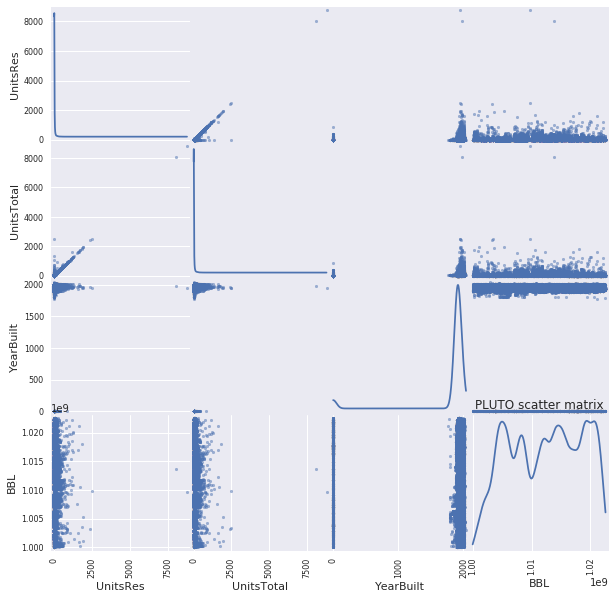

In [21]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')
pl.title('PLUTO scatter matrix')

Figure 3: The correlations for the PLUTO data are much easier to read once narrowed down to a few columns. Correlations seems strong for units res and units total all others seem to be low or little correlation.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'Heatmap of correlations for PLUTO data')

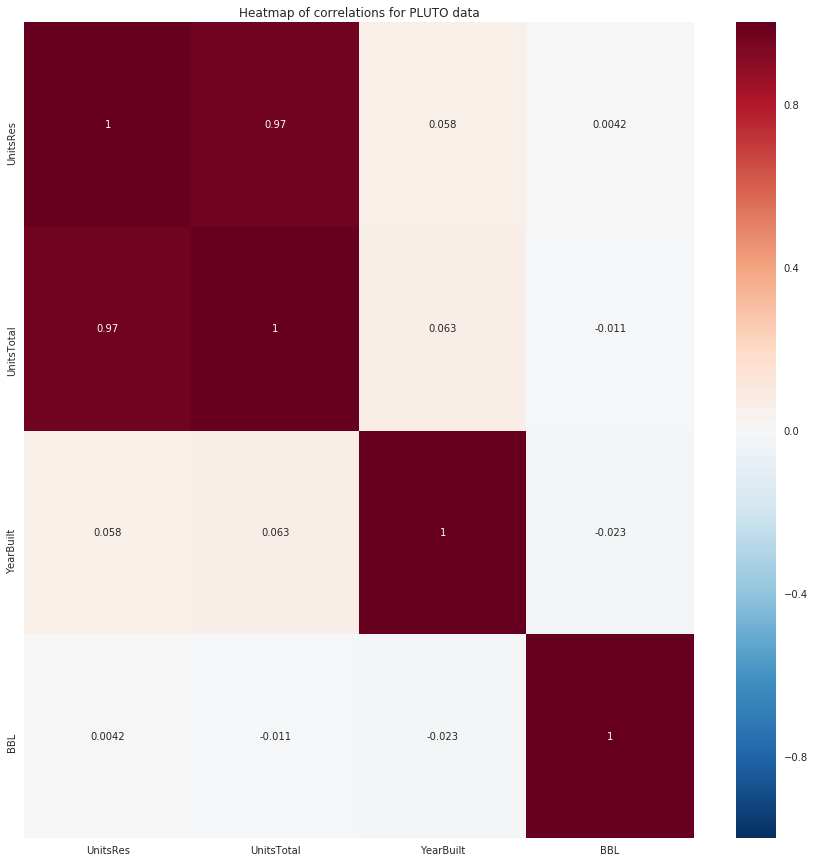

In [22]:
pl.figure(figsize = (15,15))
sns.heatmap(bsize.corr(), annot=True)
pl.title('Heatmap of correlations for PLUTO data')

Figure 4: the heatmap above confirms the theory with the scatter matrix

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [23]:
nrg.dtypes

BBL                                                 float64
Site EUI(kBtu/ft2)                                   object
Reported Property Floor Area (Building(s)) (ft²)     object
dtype: object

In [24]:
nrg.head()
#need to convert site EUI and reported floor area

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [25]:
bsize.dtypes

UnitsRes        int64
UnitsTotal      int64
YearBuilt       int64
BBL           float64
geometry       object
dtype: object

In [26]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


In [27]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')

In [28]:
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = \
pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

In [29]:
nrg.dtypes

BBL                                                 float64
Site EUI(kBtu/ft2)                                  float64
Reported Property Floor Area (Building(s)) (ft²)    float64
dtype: object

In [30]:
##check that your conversion worked: e.g.
for x in nrg:
    print (nrg[x][:10])
for x in bsize:
    print (bsize[x][:10])
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


0    1.000410e+09
1    4.021460e+09
2    2.027620e+09
3    1.006700e+09
4    2.048300e+09
5    2.006120e+09
6    3.050770e+09
7    3.065710e+09
8    4.004490e+09
9    3.072240e+09
Name: BBL, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Site EUI(kBtu/ft2), dtype: float64
0    918919.0
1         NaN
2     64200.0
3         NaN
4     50000.0
5     61800.0
6    102198.0
7     46620.0
8         NaN
9     54029.0
Name: Reported Property Floor Area (Building(s)) (ft²), dtype: float64
0    16
1    50
2    10
3    29
4    26
5     2
6     0
7     0
8    30
9    10
Name: UnitsRes, dtype: int64
0    18
1    50
2    10
3    32
4    26
5     3
6     8
7     2
8    30
9    10
Name: UnitsTotal, dtype: int64
0    1920
1    1914
2    1910
3    1928
4    1900
5    1910
6    1920
7    1915
8    1915
9    1900
Name: YearBuilt, dtype: int64
0    1.015450e+09
1    1.007238e+09
2    1.016800e+09
3    1.013850e+09
4    1.011970e+09
5    1.002360e+09
6   

In [31]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [32]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [33]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919.0
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200.0
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000.0


In [34]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
#first creating geo
bblnrgdataGPD = bsize.merge(nrg, on='BBL')
#next merging other way to create normal
bblnrgdata = nrg.merge(bsize, on='BBL')

In [35]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry
0,1.006700e+09,NaN,NaN,0,1,1987,"POLYGON ((982544.9470214844 212642.966796875, ..."
1,1.004370e+09,NaN,NaN,0,4,1920,"POLYGON ((988632.9398193359 204610.9329833984,..."
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,..."
3,1.009220e+09,NaN,NaN,148,148,1963,"POLYGON ((989369.5852050781 206338.7576293945,..."
4,1.007400e+09,NaN,68329.0,0,1,1920,"POLYGON ((983418.6008300781 209632.8702392578,..."


In [36]:
type(bblnrgdata)

pandas.core.frame.DataFrame

In [37]:
type(bblnrgdataGPD)

geopandas.geodataframe.GeoDataFrame

In [38]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

In [39]:
# as seen in slack, posted by Rufei Sheng
np.log(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)']+1)

0       11.470488
1       12.240426
2       10.876556
3       11.496389
4       11.944714
5       11.022735
6             NaN
7       11.166950
8       11.223268
9       12.271153
10      11.052650
11      11.619418
12      11.154835
13      12.038251
14            NaN
15            NaN
16      11.640439
17      11.424105
18      10.971555
19      13.611173
20      11.605486
21      10.929547
22            NaN
23            NaN
24      13.008493
25      12.381445
26            NaN
27      11.915974
28      11.267460
29      11.134209
          ...    
6408          NaN
6409    14.352638
6410    13.530493
6411          NaN
6412          NaN
6413    12.517725
6414    13.987870
6415          NaN
6416    13.922481
6417    13.612586
6418    13.933598
6419    13.060152
6420    11.486900
6421    14.668305
6422    13.618981
6423    13.610180
6424    11.031303
6425    11.111507
6426    11.327054
6427    11.629810
6428    13.048930
6429    11.387464
6430    11.095378
6431    12.085469
6432    12

In [40]:
# create new columns with the log of the area and the log of energy used-- 
# adding one so log(0) is not taken
bblnrgdataGPD['logarea'] = \
    np.log(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)']+1)
bblnrgdataGPD['lognrg'] = np.log(bblnrgdataGPD['Site EUI(kBtu/ft2)']+1)

In [41]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logarea,lognrg
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0,11.470488,4.244200
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0,12.240426,4.481872
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0,10.876556,4.951593
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0,11.496389,4.579852
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0,11.944714,3.621671


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'Log Energy Used of the PLUTO Map')

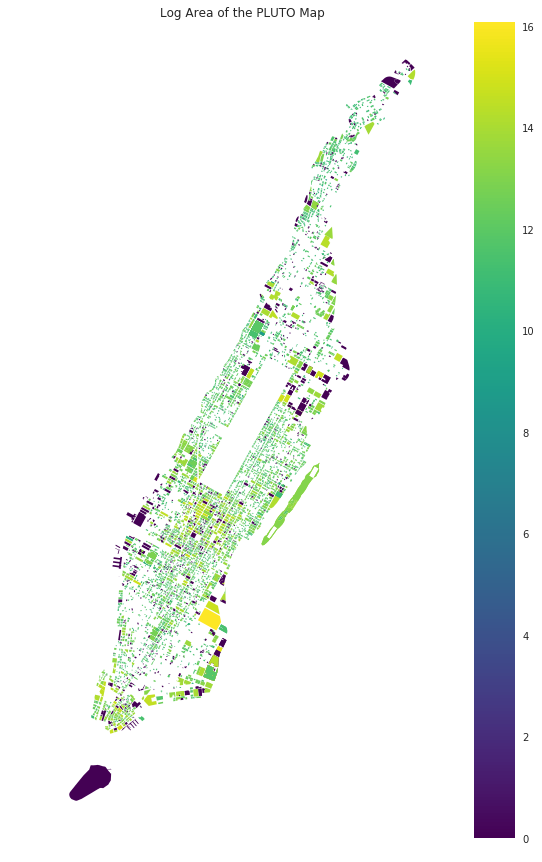

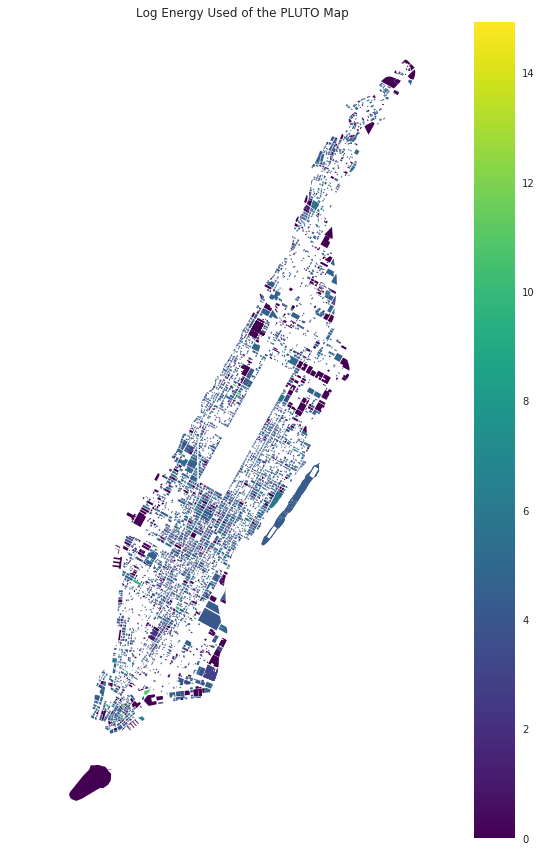

In [42]:
# https://matplotlib.org/examples/color/colormaps_reference.html
# color was coming out black and white, looked up a choropleth color pallette 
#fig = pl.figure(figsize=(15,15))

#Area
bblnrgdataGPD.plot(column='logarea', figsize=(15,15), legend=True, cmap='viridis').axis('off')
pl.title('Log Area of the PLUTO Map')

#energy use
bblnrgdataGPD.plot(column='lognrg', figsize=(15,15), legend=True, cmap='viridis').axis('off')
pl.title('Log Energy Used of the PLUTO Map')



Figure 5: though  the graphs look right and highlight very clear areas with high and low log areas, the scale is not correct, trying again after more inspection.

In [43]:
#looking at some histograms to see if the distribution of the log area nad the log energy tell me anything

Text(0.5,1,'histogram for log of area')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


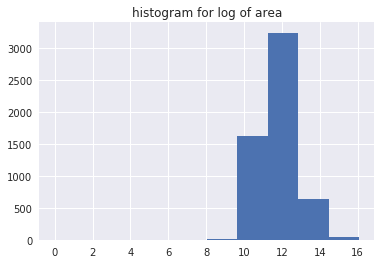

In [44]:
bblnrgdataGPD['logarea'].hist()
pl.title('histogram for log of area')

Text(0.5,1,'histogram for log of energy use')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


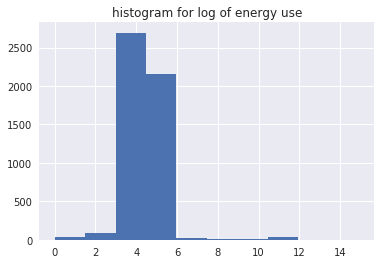

In [45]:
bblnrgdataGPD['lognrg'].hist()
pl.title('histogram for log of energy use')

In [46]:
#seems to have a larger spread than originally suggested. 

In [47]:
# the scale seems incorrect compared to other examples. Slack and googling informed me that I might want to do a different 
# log base of 10

In [48]:
# create new columns with the log of the area and the log of energy used-- 
# adding one so log(0) is not taken
bblnrgdataGPD['logarea'] = \
    np.log10(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)']+1)
bblnrgdataGPD['lognrg'] = np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)']+1)

In [49]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),logarea,lognrg
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0,4.981569,1.843233
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0,5.315949,1.946452
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0,4.723628,2.150449
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0,4.992819,1.989005
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0,5.187524,1.572872


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'Log Energy Used of the PLUTO Map')

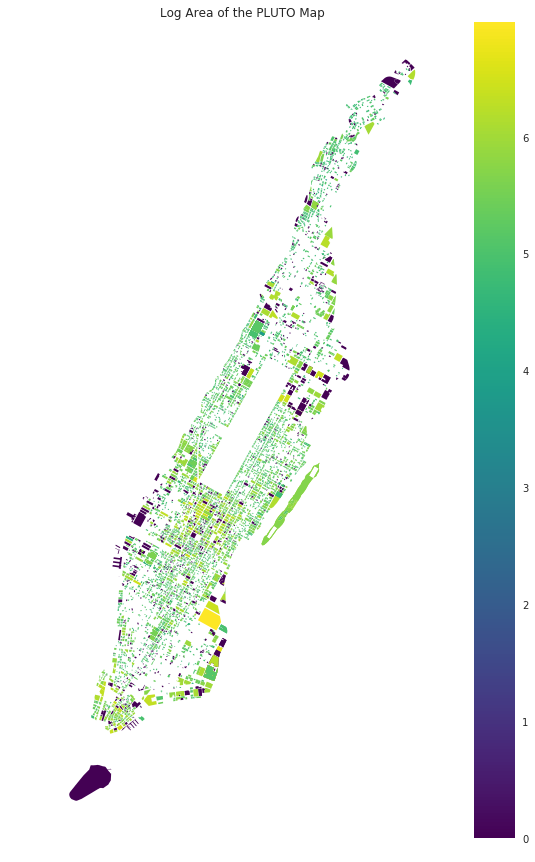

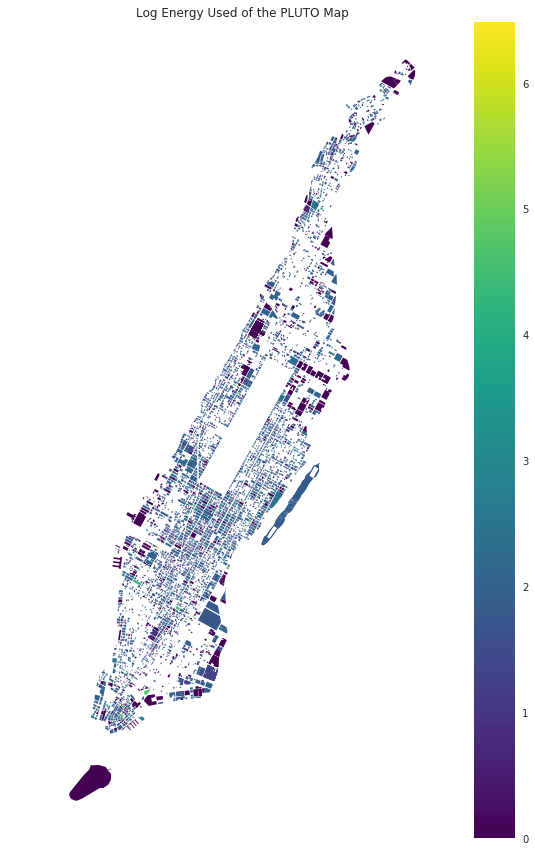

In [50]:
# https://matplotlib.org/examples/color/colormaps_reference.html
# color was coming out black and white, looked up a choropleth color pallette 
#fig = pl.figure(figsize=(15,15))

#Area
bblnrgdataGPD.plot(column='logarea', figsize=(15,15), legend=True, cmap='viridis').axis('off')
pl.title('Log Area of the PLUTO Map')

#energy use
bblnrgdataGPD.plot(column='lognrg', figsize=(15,15), legend=True, cmap='viridis').axis('off')
pl.title('Log Energy Used of the PLUTO Map')


Figure 6: the log of energy still doesn't seem to match up, need to ask for help. 
From evaluating the first graph you can see very clear sections with larger areas (yellow) like stuy town. the sections with smaller (purple areas) are scattered throughout. 

The distribution of the energy is pretty skewed, but you can see a few areas with high energy usage in light green. narrowing down the PLUTOs to those with middle 50% could show more differences amongst them. 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


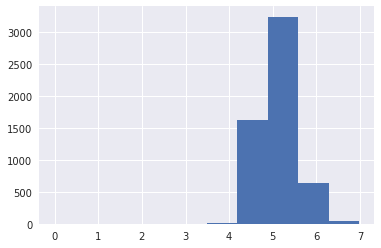

In [51]:
bblnrgdataGPD['logarea'].hist()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


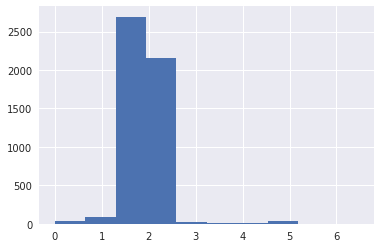

In [52]:
bblnrgdataGPD['lognrg'].hist()

In [53]:
bblnrgdataGPD['lognrg'].dropna().describe()

count    5047.000000
mean        1.924926
std         0.368739
min         0.000000
25%         1.825426
50%         1.924279
75%         2.021603
max         6.479790
Name: lognrg, dtype: float64

In [54]:
# create new columns with the log of the area and the log of energy used-- 
# adding one so log(0) is not taken
bblnrgdataGPD['logarea'] = \
    np.log(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)']+1)
bblnrgdataGPD['lognrg'] = np.log(bblnrgdataGPD['Site EUI(kBtu/ft2)']+1)

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [55]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry
0,1.006700e+09,NaN,NaN,0,1,1987,"POLYGON ((982544.9470214844 212642.966796875, ..."
1,1.004370e+09,NaN,NaN,0,4,1920,"POLYGON ((988632.9398193359 204610.9329833984,..."
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,..."
3,1.009220e+09,NaN,NaN,148,148,1963,"POLYGON ((989369.5852050781 206338.7576293945,..."
4,1.007400e+09,NaN,68329.0,0,1,1920,"POLYGON ((983418.6008300781 209632.8702392578,..."


In [56]:
bblnrgdata.dtypes

BBL                                                 float64
Site EUI(kBtu/ft2)                                  float64
Reported Property Floor Area (Building(s)) (ft²)    float64
UnitsRes                                              int64
UnitsTotal                                            int64
YearBuilt                                             int64
geometry                                             object
dtype: object

In [57]:
## multiplying area by energy/area to get total energy per building
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area (Building(s)) (ft²)'] *\
                bblnrgdata['Site EUI(kBtu/ft2)']



In [58]:
bblnrgdata['nrg'].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    5.039000e+03
mean     2.132715e+08
std      5.260042e+09
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      3.501452e+11
Name: nrg, dtype: float64

In [59]:
np.nonzero(bblnrgdata['nrg'])

(array([   0,    1,    2, ..., 6435, 6436, 6437]),)

In [60]:
print ('maximum building energy value: ' + str(bblnrgdata['nrg'].max()))
print ('minimum building energy value: ' + str(bblnrgdata['nrg'][bblnrgdata['nrg'] != 0].min()))
#minimum that is non zero                       

maximum building energy value: 350145188000.0
minimum building energy value: 5344.0


Text(0,0.5,'Number of Units in Building')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


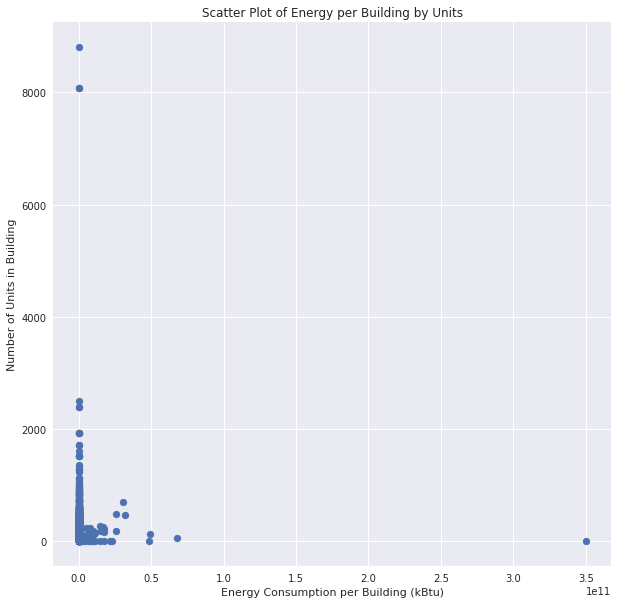

In [61]:
pl.figure(figsize=(10,10))
pl.scatter(x=bblnrgdata['nrg'], y=bblnrgdata['UnitsTotal'])
pl.title('Scatter Plot of Energy per Building by Units')
pl.xlabel('Energy Consumption per Building (kBtu)')
pl.ylabel('Number of Units in Building')

Figure 7: First time graphing was not the right scale, though there may be some positive correlation suggested here. 

(0, 1000)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


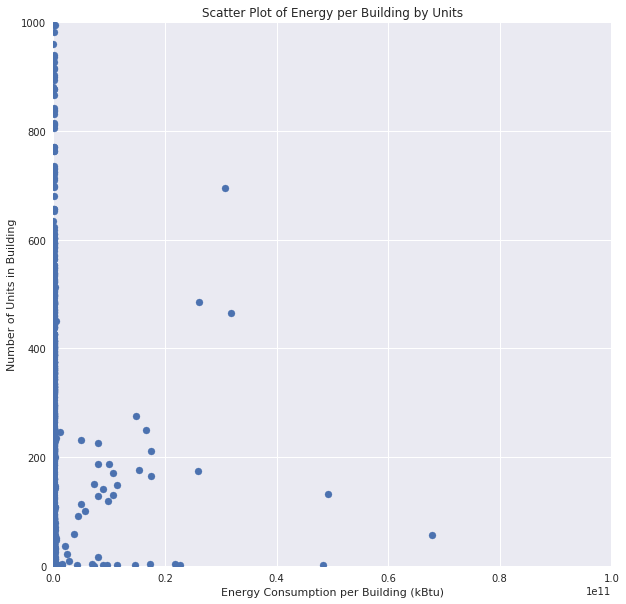

In [62]:
pl.figure(figsize=(10,10))
pl.scatter(x=bblnrgdata['nrg'], y=bblnrgdata['UnitsTotal'])
pl.title('Scatter Plot of Energy per Building by Units')
pl.xlabel('Energy Consumption per Building (kBtu)')
pl.ylabel('Number of Units in Building')
pl.xlim(0,1e11) #important to note that the number is in scientific notation
pl.ylim(0,1000)



Figure 8: Second time plotting the graph.The positive correlation is much more apparent here between the number of units and energy consumed. Those buildings at 0 energy may be explained by something else? I believe the next part might address this.  

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





Text(0,0.5,'$log_{10}$(x)')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


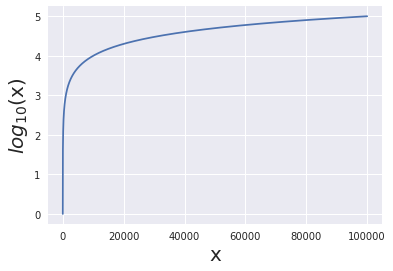

In [63]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20)

Figure 10: graph of how log10(x) changes as x increases

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


# I believe the units are the independent variable and the dependent varibale is energy consumption

(1000, 10000000000.0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


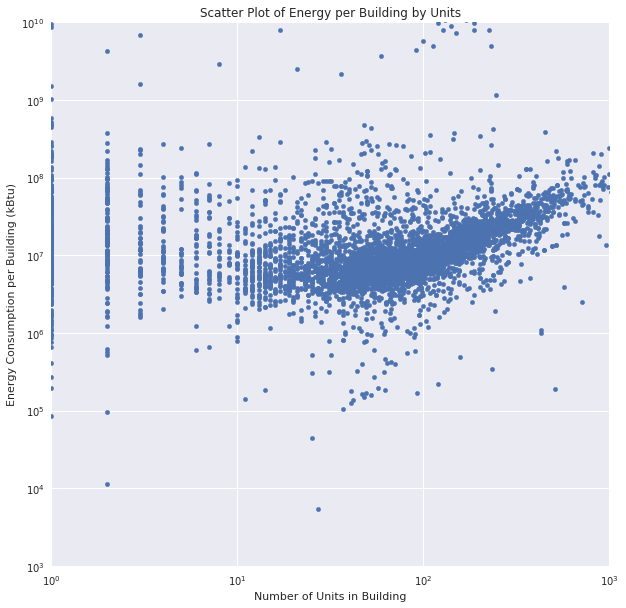

In [64]:

bblnrgdata.plot(kind='scatter', x='UnitsTotal', y='nrg', loglog=True, figsize=(10,10))
pl.title('Scatter Plot of Energy per Building by Units')
pl.ylabel('Energy Consumption per Building (kBtu)')
pl.xlabel('Number of Units in Building')
pl.xlim(1,1000) 
pl.ylim(1000,1e10)

Figure 11 : The correlation has become more clear in this sense. The amount of units since is likely an integer can be seen more stratified. the shape here looks similar to a parabola 

(1000, 10000000000.0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


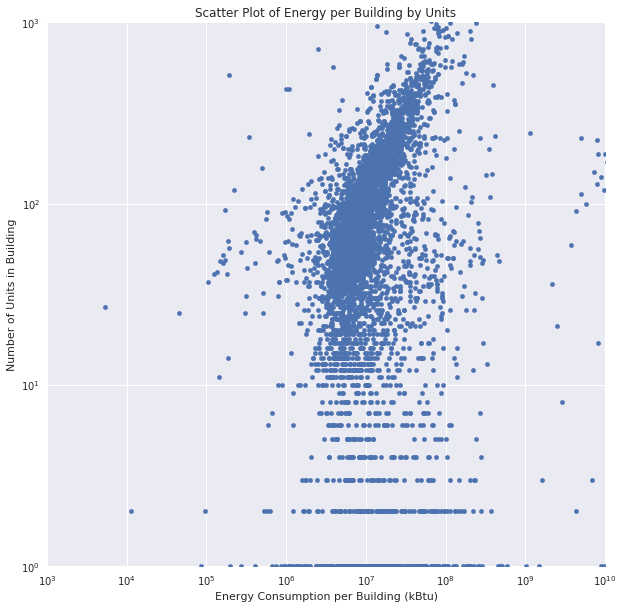

In [65]:
#as requested, showing the other way
bblnrgdata.plot(kind='scatter', y='UnitsTotal', x='nrg', loglog=True, figsize=(10,10))
pl.title('Scatter Plot of Energy per Building by Units')
pl.xlabel('Energy Consumption per Building (kBtu)')
pl.ylabel('Number of Units in Building')
pl.ylim(1,1000) 
pl.xlim(1000,1e10)

Figure 12 : Now it looks more like a fish... but seriously looking at it this way almost makes it look like a vertical line would fit best. 

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer**

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Units vs Energy

In [66]:
#drop nans where applicable
bblnrgdata.dropna(subset=['nrg', 'UnitsTotal'], inplace=True)

In [67]:
#limit the dataframe to only necassary records
bblnrgdata = bblnrgdata[bblnrgdata['nrg'] >= 1000][bblnrgdata['nrg'] <= 1e10]
bblnrgdata = bblnrgdata[bblnrgdata['UnitsTotal'] >= 1][bblnrgdata['UnitsTotal'] <= 1000]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [68]:
# first units as the independent 

In [69]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,nrg
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,...",41382000.0
10,1.010140e+09,154.9,841709.0,0,2,1999,"POLYGON ((987726.6307983398 214846.9885864258,...",130380724.1
15,1.007660e+09,122.3,59468.0,0,8,1912,"POLYGON ((984350.5375976562 209226.3930053711,...",7272936.4
16,1.008150e+09,117.0,364000.0,0,64,1954,"POLYGON ((988118.5700073242 213939.774597168, ...",42588000.0
18,1.005050e+09,82.1,235370.0,0,24,1926,"POLYGON ((982849.6038208008 203886.2427978516,...",19323877.0


In [70]:
#make new column with log values
bblnrgdata['logunits'] = np.log10(bblnrgdata['UnitsTotal']+1)
bblnrgdata['lognrg'] = np.log10(bblnrgdata['nrg']+1)

In [71]:
#sorting for graphing
bblnrgdata.sort_values(by='logunits', inplace=True)
bblnrgdata.reset_index(drop=True, inplace=True)

In [72]:
#fitting linear 
fitols_unit = smf.ols(formula='lognrg ~ logunits', data=bblnrgdata).fit()
fitols_unit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     123.5
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           2.33e-28
Time:                        13:46:47   Log-Likelihood:                -3276.9
No. Observations:                4928   AIC:                             6558.
Df Residuals:                    4926   BIC:                             6571.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      6.8265      0.020    336.374      0.000         6.787     6.866
logunits       0.1245      0.011     11.114      0.000         0.103     0.146
==============================================================================
Omnibus:                     1286.414   Durbin-Watson:                   1.607
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10437.593
Skew:                           1.018   Prob(JB):                         0.00
Kurtosis:                       9.833   Cond. No.                         7.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
bblnrgdata.describe()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,nrg,logunits,lognrg
count,4.928000e+03,4928.000000,4.928000e+03,4928.00000,4928.000000,4928.000000,4.928000e+03,4928.000000,4928.000000
mean,1.012064e+09,306.270556,2.060576e+05,89.22017,101.442776,1941.414367,4.662477e+07,1.709547,7.039371
std,5.510177e+06,3631.001235,2.854708e+05,122.98452,124.140389,69.633046,4.408256e+08,0.598332,0.476401
min,1.000048e+09,0.100000,2.700000e+03,0.00000,1.000000,0.000000,5.344000e+03,0.301030,3.727948
25%,1.008298e+09,66.000000,7.192875e+04,0.00000,28.000000,1920.000000,5.859917e+06,1.462398,6.767892
50%,1.012410e+09,82.900000,1.150000e+05,56.00000,64.000000,1930.000000,9.225494e+06,1.812913,6.964990
75%,1.015170e+09,103.700000,2.150988e+05,113.00000,122.000000,1965.000000,1.826716e+07,2.089905,7.261671
max,1.022500e+09,112726.600000,5.207812e+06,995.00000,995.000000,2016.000000,9.926784e+09,2.998259,9.996809


In [74]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,nrg,logunits,lognrg
0,1.013390e+09,85.2,187060.0,0,1,1928,"POLYGON ((992748.2170410156 213381.6386108398,...",15937512.0,0.30103,7.202421
1,1.008400e+09,92.3,126374.0,0,1,1930,"POLYGON ((988430.1754150391 213473.1265869141,...",11664320.2,0.30103,7.066859
2,1.003790e+09,31.4,104680.0,0,1,1928,"POLYGON ((991023.1190185547 203395.1254272461,...",3286952.0,0.30103,6.516793
3,1.008400e+09,51.6,60449.0,0,1,1910,"POLYGON ((988789.4260253906 213157.9298095703,...",3119168.4,0.30103,6.494039
4,1.008400e+09,24.1,51273.0,0,1,1916,"POLYGON ((988877.6368408203 213223.0231933594,...",1235679.3,0.30103,6.091906


In [75]:
#create a column for prediction--- only way I could get graphing to work
bblnrgdata['predict_nrg'] = fitols_unit.predict(bblnrgdata)

(2, 12)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


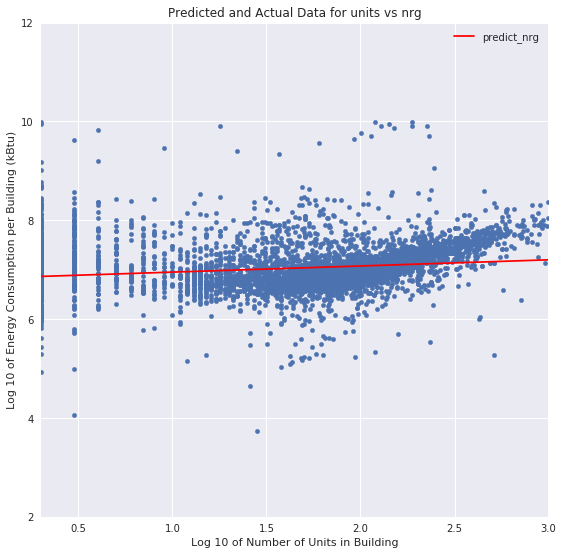

In [76]:
fig = pl.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)

bblnrgdata.plot(kind='scatter', x='logunits', y='lognrg', ax=ax1)
bblnrgdata.plot(x='logunits', y='predict_nrg', c='r', ax=ax1)
pl.title('Predicted and Actual Data for units vs nrg')
pl.ylabel('Log 10 of Energy Consumption per Building (kBtu)')
pl.xlabel('Log 10 of Number of Units in Building')
pl.ylim(2,12) 
#pl.xlim(1000,1e10)




Figure 13: we see here that the model does pretty well at going through the middle of the bulk of the points, but it does not follow the curve. This could be solved by a polynomial fit

### Energy against Units

In [77]:
# then energy as the independent 

In [78]:
bblnrgdata.sort_values(by='lognrg', inplace=True)
bblnrgdata.reset_index(drop=True, inplace=True)

In [79]:
bblnrgdata.columns

Index(['BBL', 'Site EUI(kBtu/ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)', 'UnitsRes',
       'UnitsTotal', 'YearBuilt', 'geometry', 'nrg', 'logunits', 'lognrg',
       'predict_nrg'],
      dtype='object')

In [80]:
fitols_nrg = smf.ols(formula='logunits ~ lognrg', data=bblnrgdata).fit()
fitols_nrg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logunits   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     123.5
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           2.33e-28
Time:                        13:46:48   Log-Likelihood:                -4399.9
No. Observations:                4928   AIC:                             8804.
Df Residuals:                    4926   BIC:                             8817.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3268      0.125      2.621      0.009         0.082     0.571
lognrg         0.1964      0.018     11.114      0.000         0.162     0.231
==============================================================================
Omnibus:                      650.785   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              932.635
Skew:                          -1.024   Prob(JB):                    3.03e-203
Kurtosis:                       3.589   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
fitols_nrg.predict(bblnrgdata)

array([ 1.0590757 ,  1.12312525,  1.24026148, ...,  2.28749236,
        2.28868817,  2.29048466])

In [82]:
bblnrgdata['predict_units'] = fitols_nrg.predict(bblnrgdata)

(2, 12)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


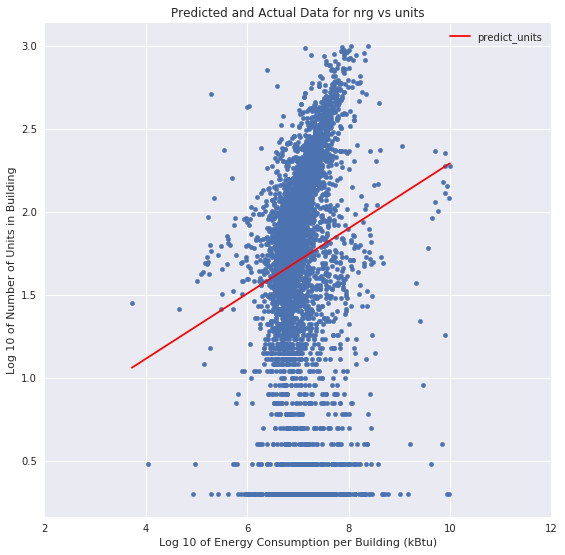

In [83]:
fig = pl.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)

bblnrgdata.plot(kind='scatter', y='logunits', x='lognrg', ax=ax1)
bblnrgdata.plot(x='lognrg', y='predict_units', c='r', ax=ax1)
pl.title('Predicted and Actual Data for nrg vs units')
pl.xlabel('Log 10 of Energy Consumption per Building (kBtu)')
pl.ylabel('Log 10 of Number of Units in Building')
pl.xlim(2,12) 

Figure 14: This fit does not seem appropriate at all. Mainly because the independent and dependent variables should likely be reversed.

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [84]:
# first units as the independent 

In [85]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,nrg,logunits,lognrg,predict_nrg,predict_units
0,1.019900e+09,0.1,53440.0,27,27,1909,"POLYGON ((994066.3934326172 234073.4490356445,...",5344.0,1.447158,3.727948,7.006695,1.059076
1,1.005350e+09,0.1,113233.0,0,2,1990,"POLYGON ((985466.5781860352 204872.9782104492,...",11323.3,0.477121,4.054011,6.885897,1.123125
2,1.019900e+09,0.9,49668.0,25,25,1910,"POLYGON ((994172.2518310547 234473.0010375977,...",44701.2,1.414973,4.650329,7.002688,1.240261
3,1.008600e+09,1.0,84550.0,0,1,1920,"POLYGON ((988846.7941894531 210694.9346313477,...",84550.0,0.301030,4.927119,6.863968,1.294632
4,1.006170e+09,0.6,160000.0,0,2,1964,"POLYGON ((983866.232421875 208013.6628417969, ...",96000.0,0.477121,4.982276,6.885897,1.305467


In [86]:
# square information for the purpose of creating polynomial
bblnrgdata['logunits2'] = bblnrgdata['logunits']**2
bblnrgdata['lognrg2'] = bblnrgdata['lognrg']**2

In [87]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,nrg,logunits,lognrg,predict_nrg,predict_units,logunits2,lognrg2
0,1.019900e+09,0.1,53440.0,27,27,1909,"POLYGON ((994066.3934326172 234073.4490356445,...",5344.0,1.447158,3.727948,7.006695,1.059076,2.094266,13.897594
1,1.005350e+09,0.1,113233.0,0,2,1990,"POLYGON ((985466.5781860352 204872.9782104492,...",11323.3,0.477121,4.054011,6.885897,1.123125,0.227645,16.435008
2,1.019900e+09,0.9,49668.0,25,25,1910,"POLYGON ((994172.2518310547 234473.0010375977,...",44701.2,1.414973,4.650329,7.002688,1.240261,2.002150,21.625559
3,1.008600e+09,1.0,84550.0,0,1,1920,"POLYGON ((988846.7941894531 210694.9346313477,...",84550.0,0.301030,4.927119,6.863968,1.294632,0.090619,24.276499
4,1.006170e+09,0.6,160000.0,0,2,1964,"POLYGON ((983866.232421875 208013.6628417969, ...",96000.0,0.477121,4.982276,6.885897,1.305467,0.227645,24.823072


In [88]:
#sort for graphing
bblnrgdata.sort_values(by='logunits2', inplace=True)
bblnrgdata.reset_index(drop=True, inplace=True)

In [89]:
fitols_unit_poly = smf.ols(formula='lognrg ~ logunits2 + logunits', data=bblnrgdata).fit()
fitols_unit_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lognrg   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     499.7
Date:                Wed, 28 Nov 2018   Prob (F-statistic):          2.54e-198
Time:                        13:46:49   Log-Likelihood:                -2882.7
No. Observations:                4928   AIC:                             5771.
Df Residuals:                    4925   BIC:                             5791.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.5139      0.030    249.912      0.000         7.455     7.573
logunits2      0.3928      0.013     29.232      0.000         0.366     0.419
logunits      -1.0312      0.041    -25.233      0.000        -1.111    -0.951
==============================================================================
Omnibus:                     1420.622   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18979.283
Skew:                           0.998   Prob(JB):                         0.00
Kurtosis:                      12.405   Cond. No.                         35.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
# for graphing
bblnrgdata['predict_nrg_poly'] = fitols_unit_poly.predict(bblnrgdata)

(2, 12)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


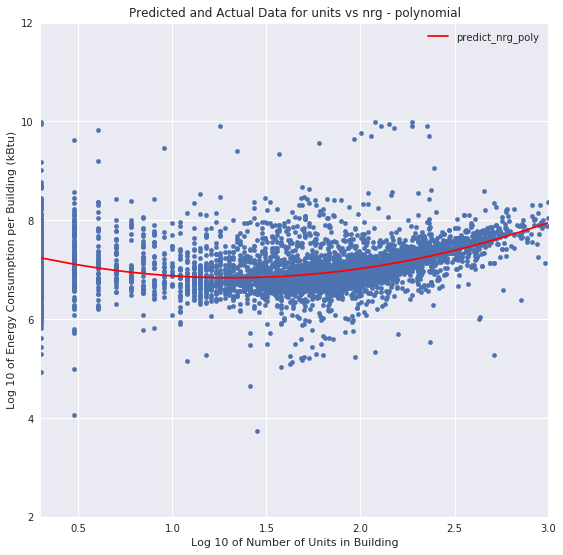

In [91]:
fig = pl.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)

bblnrgdata.plot(kind='scatter', x='logunits', y='lognrg', ax=ax1)
bblnrgdata.plot(x='logunits', y='predict_nrg_poly', c='r', ax=ax1)
pl.title('Predicted and Actual Data for units vs nrg - polynomial')
pl.ylabel('Log 10 of Energy Consumption per Building (kBtu)')
pl.xlabel('Log 10 of Number of Units in Building')
pl.ylim(2,12) 
#pl.xlim(1000,1e10)




Figure 15: When you talk about a good fit, this is exactly what I envisioned. the line goes in the middle of the bulk of the data points which means residuals are minimized. 

In [92]:
#next the other method where independent is energy

In [93]:
bblnrgdata.sort_values(by='lognrg2', inplace=True)
bblnrgdata.reset_index(drop=True, inplace=True)

In [94]:
fitols_nrg_poly = smf.ols(formula='logunits ~ lognrg2 + lognrg', data=bblnrgdata).fit()
fitols_nrg_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logunits   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     106.1
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           7.91e-46
Time:                        13:46:49   Log-Likelihood:                -4357.0
No. Observations:                4928   AIC:                             8720.
Df Residuals:                    4925   BIC:                             8740.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.1922      0.712     -8.699      0.000        -7.588    -4.797
lognrg2       -0.1250      0.013     -9.300      0.000        -0.151    -0.099
lognrg         2.0063      0.195     10.267      0.000         1.623     2.389
==============================================================================
Omnibus:                      621.865   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.432
Skew:                          -0.990   Prob(JB):                    1.78e-191
Kurtosis:                       3.595   Cond. No.                     4.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [95]:
bblnrgdata['predict_units_poly'] = fitols_nrg_poly.predict(bblnrgdata)

(0, 4)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


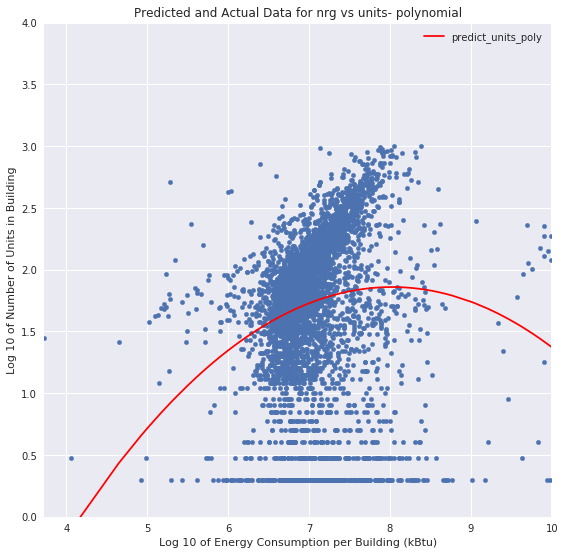

In [96]:
fig = pl.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)

bblnrgdata.plot(kind='scatter', y='logunits', x='lognrg', ax=ax1)
bblnrgdata.plot(x='lognrg', y='predict_units_poly', c='r', ax=ax1)
pl.title('Predicted and Actual Data for nrg vs units- polynomial')
pl.xlabel('Log 10 of Energy Consumption per Building (kBtu)')
pl.ylabel('Log 10 of Number of Units in Building')
pl.ylim(0,4) 





Figure 16: Once again the reverse variables doesn't seem to apply as well as units being independent. This can clearly be seen here. 

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

In [97]:
# Thanks to Ilyas for help with this error bar calculation-- can be seen in the description above
nrgerror = np.sqrt(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)']**2 +
                   (bblnrgdata['Site EUI(kBtu/ft2)']**2))

# Thanks to Ilyas for help with this error bar calculation-- can be seen in the description above
bblnrgdata['errorsnrg'] = np.abs(nrgerror/bblnrgdata['nrg']/np.log(10))
bblnrgdata['errorsunits'] = np.abs(np.sqrt(bblnrgdata['UnitsTotal'])/bblnrgdata['UnitsTotal']/np.log(10))

The largest error bar is for


,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,nrg,logunits,lognrg,predict_nrg,predict_units,logunits2,lognrg2,predict_nrg_poly,predict_units_poly,errorsnrg,errorsunits
0,1.019900e+09,0.1,53440.0,27,27,1909,"POLYGON ((994066.3934326172 234073.4490356445,...",5344.0,1.447158,3.727948,7.006695,1.059076,2.094266,13.897594,6.84406,-0.449772,4.342945,0.08358


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


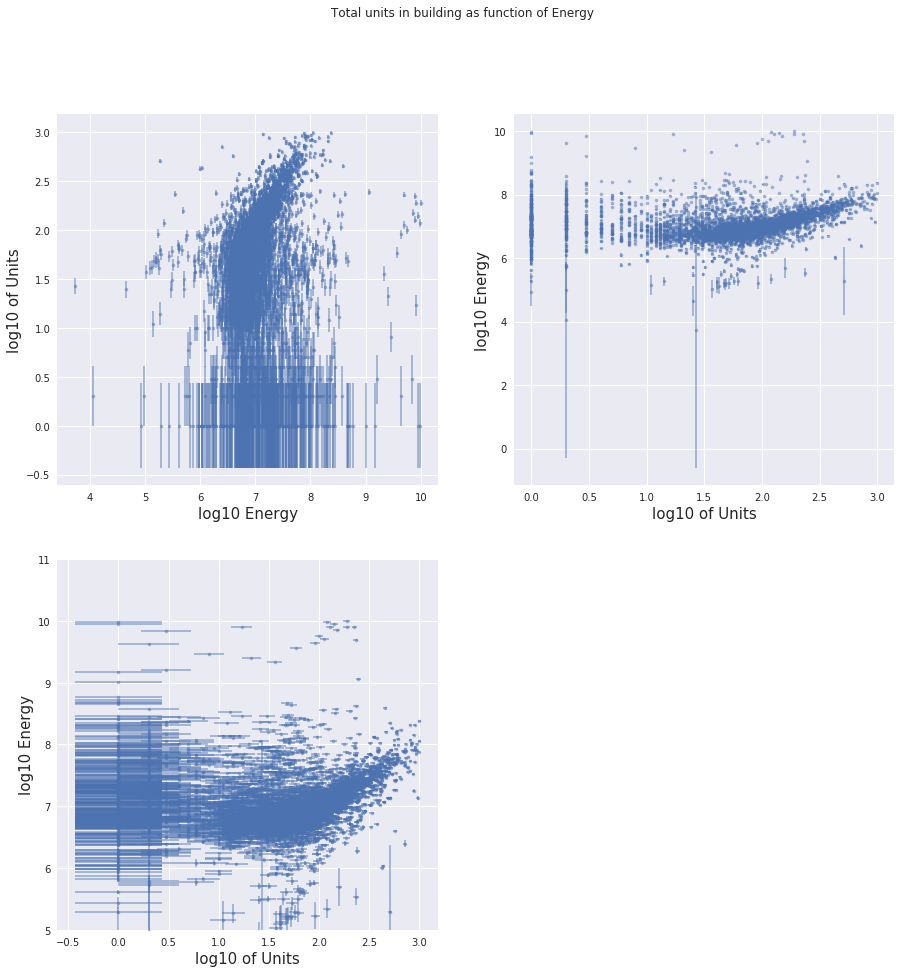

In [98]:
#adjusted from the provided code 

fig = pl.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.errorbar(np.log10(bblnrgdata['nrg']), np.log10(bblnrgdata['UnitsTotal']), 
            yerr=bblnrgdata['errorsunits'], fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = fig.add_subplot(222)
ax2.errorbar(np.log10(bblnrgdata['UnitsTotal']), np.log10(bblnrgdata['nrg']), 
            yerr=bblnrgdata['errorsnrg'], fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax3 = fig.add_subplot(223)
ax3.errorbar(np.log10(bblnrgdata['UnitsTotal']), np.log10(bblnrgdata['nrg']), 
            yerr=bblnrgdata['errorsnrg'],
           xerr=bblnrgdata['errorsunits'], alpha=0.5, fmt='.')
ax3.set_xlabel("log10 of Units", fontsize=15)
ax3.set_ylabel("log10 Energy", fontsize=15)
ax3.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdata[bblnrgdata['errorsnrg'] == bblnrgdata['errorsnrg'].max()]


Figure 17: This figure is very similar to previous graphs, but this one shoes error bars. Due to the nature of calculating error bars, you can see the bars increase as they are further away from the center of the cluster. As mentioned below, this is done using poisson statistics.

Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square

In [99]:
# Thanks to Ilyas for help with this
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        calc = np.sum((model - data)**2/errors**2)
        return(calc)


### calculate the degrees of freedom of this model

In [100]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(bblnrgdata) - 2
print ("degrees of freedom:" , dof)
print (fitols_unit.df_resid)
print (fitols_nrg.df_resid)


degrees of freedom: 4926
4926.0
4926.0


In [101]:
#check to be sure they are the same 

In [102]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,nrg,logunits,lognrg,predict_nrg,predict_units,logunits2,lognrg2,predict_nrg_poly,predict_units_poly,errorsnrg,errorsunits
0,1.019900e+09,0.1,53440.0,27,27,1909,"POLYGON ((994066.3934326172 234073.4490356445,...",5344.0,1.447158,3.727948,7.006695,1.059076,2.094266,13.897594,6.844060,-0.449772,4.342945,0.083580
1,1.005350e+09,0.1,113233.0,0,2,1990,"POLYGON ((985466.5781860352 204872.9782104492,...",11323.3,0.477121,4.054011,6.885897,1.123125,0.227645,16.435008,7.111254,-0.112708,4.342945,0.307093
2,1.019900e+09,0.9,49668.0,25,25,1910,"POLYGON ((994172.2518310547 234473.0010375977,...",44701.2,1.414973,4.650329,7.002688,1.240261,2.002150,21.625559,6.841070,0.434987,0.482549,0.086859
3,1.008600e+09,1.0,84550.0,0,1,1920,"POLYGON ((988846.7941894531 210694.9346313477,...",84550.0,0.301030,4.927119,6.863968,1.294632,0.090619,24.276499,7.239026,0.659006,0.434294,0.434294
4,1.006170e+09,0.6,160000.0,0,2,1964,"POLYGON ((983866.232421875 208013.6628417969, ...",96000.0,0.477121,4.982276,6.885897,1.305467,0.227645,24.823072,7.111254,0.701359,0.723824,0.307093


In [103]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdata['nrg']), fitols_unit.predict()) /
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdata['nrg']), fitols_unit.predict(), 
            errors = bblnrgdata['errorsnrg']) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdata['nrg']), fitols_unit.predict(), 
            errors = np.sqrt(bblnrgdata['errorsnrg']**2 + 
                             bblnrgdata['errorsunits']**2))  / dof))

Units vs Energy residuals (no errors include): 0.17
Units vs Energy chi square per DOF w independent variable error only: 274084189.38
Units vs Energy chi square per DOF : 96.41


In [104]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdata['UnitsTotal']), fitols_nrg.predict()) /
        float(dof)))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdata['UnitsTotal']), fitols_nrg.predict(), 
            errors = bblnrgdata['errorsnrg']) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdata['UnitsTotal']), fitols_nrg.predict(), 
            errors = np.sqrt(bblnrgdata['errorsnrg']**2 + 
                             bblnrgdata['errorsunits']**2))  / dof))

Energy vs Units residuals (no errors include): 0.43
Energy vs Units chi square per DOF w independent variable error only: 53515666.38
Energy vs Units chi square per DOF : 177.30


In [105]:
print ("Polynomial Model- Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdata['nrg']), fitols_unit_poly.predict()) /
        float(dof)))

print ("Polynomial Model- Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdata['nrg']), fitols_unit_poly.predict(), 
            errors = bblnrgdata['errorsnrg']) / dof))

print ("Polynomial Model- Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdata['nrg']), fitols_unit_poly.predict(), 
            errors = np.sqrt(bblnrgdata['errorsnrg']**2 + 
                             bblnrgdata['errorsunits']**2))  / dof))

Polynomial Model- Units vs Energy residuals (no errors include): 0.14
Polynomial Model- Units vs Energy chi square per DOF w independent variable error only: 145863194.16
Polynomial Model- Units vs Energy chi square per DOF : 52.34


### Compare the models using the  chi square:
Its not surprising that the chi square is closer to 1 for the energy vs units, as I have been thinking that it does not seem to be fit very well visually. Also if comparing the linear and polynomial models for those with units as an independent varibale, you'll see that the polynomial has a smaller chi sq which means it is a better fit.  

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Text(0.5,1,'Influence Plot for Energy vs Units Linear Model')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


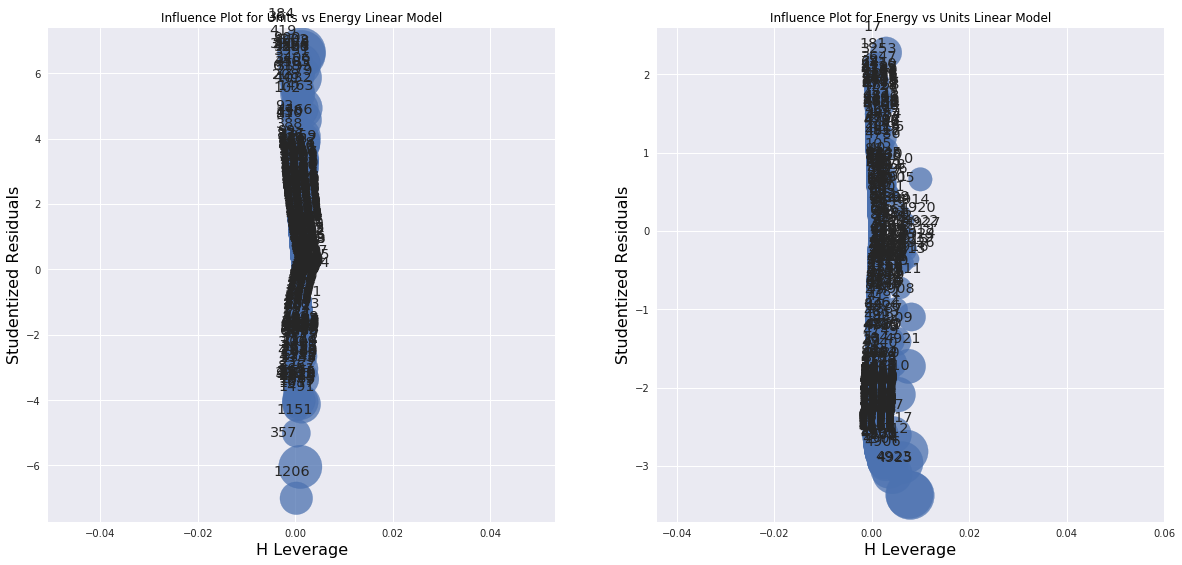

In [106]:
fig = pl.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
sm.graphics.influence_plot(fitols_unit, alpha=0.05, criterion="cooks", ax=ax1)
ax1.set_title('Influence Plot for Units vs Energy Linear Model')

ax2 = fig.add_subplot(222)
sm.graphics.influence_plot(fitols_nrg, alpha=0.05, criterion="cooks", ax=ax2)
ax2.set_title('Influence Plot for Energy vs Units Linear Model')


Figure18: this is a demostration of the residuals of each model. On the left you'll see the one most people would argue for: units is an independant. Here we see that though the residuals still vary, we see the influence of those residuals have a larger spread for the energy vs units. 

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

In [109]:
alpha = .05

Null Hypothesis: the linear model (restricted model) is better or equal to representation of the complex model (polynomial)
Hypothesis: the complex model (polynomial) is better representation than the linear model (restricted model)

In [110]:
fitols_nrg_poly.compare_lr_test(fitols_nrg)

(85.782779237075374, 2.008274847898123e-20, 1.0)

In [112]:
alpha > fitols_nrg_poly.compare_lr_test(fitols_nrg)[1]

True

We reject the null that the linear model (restricted model) is better or equal to representation of the complex model (polynomial). 

In [ ]:
#now for units as the independent 

In [115]:
fitols_unit_poly.compare_lr_test(fitols_unit)

(788.46792340344018, 1.7352610880171518e-173, 1.0)

In [116]:
alpha > fitols_unit_poly.compare_lr_test(fitols_unit)[1]

True

We reject the null that the linear model (restricted model) is better or equal to representation of the complex model (polynomial)

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

# EXTRA CREDIT: a plot of anything related to these data

In [128]:
bblnrgdata['logsite_eui'] = \
np.log10(bblnrgdata['Site EUI(kBtu/ft2)'] + 1)

Text(0.5,1,'Yearbuilt vs Energy Consumed')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


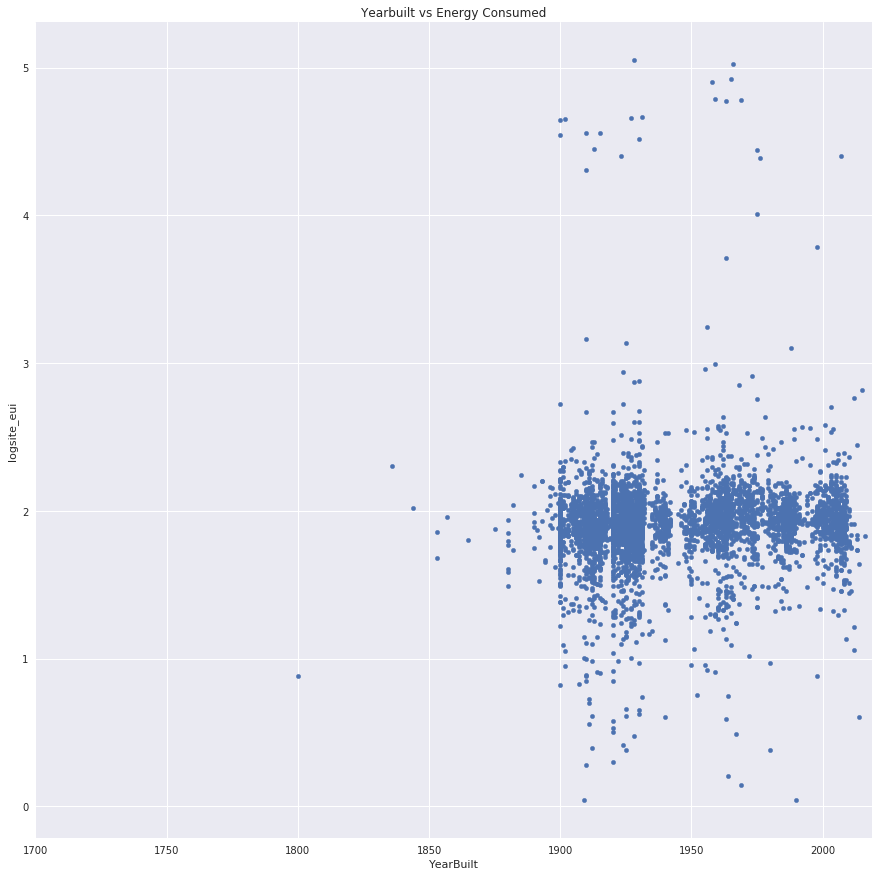

In [129]:
bblnrgdata.plot(kind='scatter', x='YearBuilt', \
                y='logsite_eui', \
                figsize=(15,15))
pl.xlim(1700,2019)
pl.title('Yearbuilt vs Energy Consumed')

Figure 19: I was curious to see the correlation of energy used per ft to year built seemed coorelated. I would have likely guessed the energy decreased due to advancements in technology. It seems as thougn the spread has become more consistent and decreased some of the outliers, but not particularly shown a decrease over time. More analysis would need to be done to consider anything further. 